# Here we implement HDP Topic Modeling

In [1]:
# imports
# Parsing Imports
import bs4 as bs
import urllib.request
import re
import string

# NPL imports
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_string,strip_tags,strip_punctuation,strip_numeric,remove_stopwords
from gensim.utils import tokenize

from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel
from gensim.models.hdpmodel import HdpModel

# visualization
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

### *Scraping*

In [2]:
scrapped_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Artificial_intelligence')
article = scrapped_data.read()

parsed_article = bs.BeautifulSoup(article, 'lxml')

paragraphs = parsed_article.find_all('p')

article_text = ""

for p in paragraphs:
    article_text += p.text
    
print(len(article_text))

62975


### *Pre-Processing*

In [3]:
# Cleaing the text
processed_article = article_text.lower()
processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
processed_article = re.sub(r'\s+', ' ', processed_article)

print(processed_article)

 artificial intelligence ai is intelligence demonstrated by machines unlike the natural intelligence displayed by humans and animals which involves consciousness and emotionality the distinction between the former and the latter categories is often revealed by the acronym chosen strong ai is usually labelled as artificial general intelligence agi while attempts to emulate natural intelligence have been called artificial biological intelligence abi leading ai textbooks define the field as the study of intelligent agents any device that perceives its environment and takes actions that maximize its chance of achieving its goals colloquially the term artificial intelligence is often used to describe machines that mimic cognitive functions that humans associate with the human mind such as learning and problem solving as machines become increasingly capable tasks considered to require intelligence are often removed from the definition of ai a phenomenon known as the ai effect a quip in tesle

In [4]:
# Loading data
data = processed_article

### *Vectorization*

In [5]:
# Creating a spacy object
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])

def vectorization(texts, allowed_postages=["NOUN", "ADJ"]):
    output = []
    for sent in texts:
        doc = nlp(sent)
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postages ])

    return output

In [6]:
tokenized_data = vectorization([data])
print(tokenized_data)

print(tokenized_data)
print("Shape : ", len(tokenized_data), len(tokenized_data[0]))


# creating dictionary to keep unique tokens
dictionary = corpora.Dictionary(tokenized_data)

# document term matrix row=doc col=word (dimention : num_words x len_dict) 
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_data]

[['artificial', 'intelligence', 'intelligence', 'machine', 'natural', 'intelligence', 'human', 'animal', 'consciousness', 'emotionality', 'distinction', 'former', 'latter', 'category', 'acronym', 'strong', 'ai', 'artificial', 'general', 'intelligence', 'agi', 'natural', 'intelligence', 'artificial', 'biological', 'intelligence', 'abi', 'ai', 'textbook', 'field', 'study', 'intelligent', 'agent', 'device', 'environment', 'action', 'chance', 'goal', 'term', 'artificial', 'intelligence', 'machine', 'cognitive', 'function', 'human', 'human', 'mind', 'such', 'learning', 'problem', 'machine', 'capable', 'task', 'intelligence', 'definition', 'ai', 'phenomenon', 'ai', 'effect', 'quip', 'theorem', 'ai', 'hasn', 't', 'instance', 'optical', 'character', 'recognition', 'thing', 'routine', 'technology', 'modern', 'machine', 'capability', 'human', 'speech', 'high', 'level', 'strategic', 'game', 'system', 'such', 'chess', 'imperfect', 'information', 'game', 'poker', 'self', 'car', 'intelligent', 'rout

In [7]:
print("Dictionary : ")
print(dictionary)
print("Document Term Matrix : ")
print(doc_term_matrix)

Dictionary : 
Dictionary(1380 unique tokens: ['aaai', 'abi', 'ability', 'able', 'abstract']...)
Document Term Matrix : 
[[(0, 2), (1, 1), (2, 10), (3, 6), (4, 1), (5, 3), (6, 1), (7, 2), (8, 1), (9, 2), (10, 2), (11, 4), (12, 1), (13, 1), (14, 1), (15, 9), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1), (21, 2), (22, 2), (23, 2), (24, 4), (25, 4), (26, 1), (27, 1), (28, 1), (29, 3), (30, 2), (31, 1), (32, 1), (33, 1), (34, 21), (35, 6), (36, 84), (37, 1), (38, 1), (39, 20), (40, 2), (41, 1), (42, 2), (43, 1), (44, 5), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 4), (52, 1), (53, 1), (54, 2), (55, 3), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 4), (63, 1), (64, 2), (65, 10), (66, 23), (67, 1), (68, 1), (69, 6), (70, 6), (71, 4), (72, 1), (73, 1), (74, 1), (75, 2), (76, 60), (77, 1), (78, 2), (79, 6), (80, 1), (81, 1), (82, 3), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 2), (90, 3), (91, 5), (92, 1), (93, 8), (94, 1), (95, 2), (96, 5), (97, 1),

### *Post-Processing Function for Tesing Sentences*

In [8]:
unwanted =["Smart" ,"smart"]
def remove_unwanted(text):  #DEfine a simple function to filter out the word 'Smart' since it is contained in almost every title
    return [word for word in tokenize(text) if word not in unwanted]

In [9]:
def custom_process(sentence):
    sentence = sentence.lower()
    no_stopwords = remove_stopwords(sentence)
    tokens = tokenize(no_stopwords)
    no_punctuation = strip_punctuation(no_stopwords)
    unwanted = remove_unwanted(no_punctuation)

    return unwanted

In [10]:
# doc for testing Model
test_doc = "Intellience and Data"
test_doc = custom_process(test_doc)
test_doc_bow = dictionary.doc2bow(test_doc)
print(test_doc_bow)

[(284, 1)]


In [11]:
# doc for testing Model
test_doc2 = "Computerand Mathematics"
test_doc2 = custom_process(test_doc2)
test_doc_bow2 = dictionary.doc2bow(test_doc2)
print(test_doc_bow2)

[(723, 1)]


### *Latent Dirichlet Allocation (LDA) Model*

In [12]:
lda = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, random_state=0)
lda_topics = lda.print_topics(num_words=5)

for topic in lda_topics:
    print(topic)

(0, '0.015*"human" + 0.014*"intelligence" + 0.012*"such" + 0.011*"artificial" + 0.011*"machine"')
(1, '0.022*"human" + 0.017*"ai" + 0.017*"intelligence" + 0.014*"such" + 0.012*"machine"')
(2, '0.016*"intelligence" + 0.011*"human" + 0.011*"artificial" + 0.011*"such" + 0.010*"ai"')
(3, '0.016*"ai" + 0.015*"intelligence" + 0.015*"human" + 0.011*"machine" + 0.009*"research"')
(4, '0.021*"ai" + 0.016*"such" + 0.015*"human" + 0.013*"machine" + 0.012*"intelligence"')
(5, '0.023*"ai" + 0.021*"human" + 0.014*"intelligence" + 0.013*"artificial" + 0.013*"problem"')
(6, '0.015*"human" + 0.014*"ai" + 0.013*"intelligence" + 0.013*"machine" + 0.009*"problem"')
(7, '0.025*"human" + 0.015*"ai" + 0.013*"artificial" + 0.013*"machine" + 0.010*"such"')
(8, '0.016*"human" + 0.011*"intelligence" + 0.011*"ai" + 0.010*"artificial" + 0.010*"machine"')
(9, '0.017*"human" + 0.016*"intelligence" + 0.014*"ai" + 0.012*"such" + 0.011*"machine"')
(10, '0.014*"human" + 0.013*"ai" + 0.011*"intelligence" + 0.008*"such" +

In [13]:
print(lda[test_doc_bow])

[(0, 0.02508729), (1, 0.02508729), (2, 0.02508729), (3, 0.02508729), (4, 0.02508729), (5, 0.02508729), (6, 0.02508729), (7, 0.02508729), (8, 0.02508729), (9, 0.02508729), (10, 0.02508729), (11, 0.02508729), (12, 0.02508729), (13, 0.02508729), (14, 0.5233415), (15, 0.02508729), (16, 0.02508729), (17, 0.02508729), (18, 0.02508729), (19, 0.02508729)]


In [14]:
print(lda[test_doc_bow2])

[(0, 0.049999993), (1, 0.049999997), (2, 0.049999993), (3, 0.049999997), (4, 0.050000004), (5, 0.049999997), (6, 0.049999997), (7, 0.049999997), (8, 0.049999993), (9, 0.049999997), (10, 0.049999993), (11, 0.049999997), (12, 0.050000023), (13, 0.049999997), (14, 0.049999997), (15, 0.049999993), (16, 0.05), (17, 0.049999993), (18, 0.049999993), (19, 0.049999993)]


In [15]:
# visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.004430 -0.001752       1        1  59.134395
5      0.004963  0.001367       2        1  40.774108
14     0.003312 -0.002461       3        1   0.070004
0     -0.000957  0.000204       4        1   0.001264
11    -0.000316  0.000773       5        1   0.001264
18    -0.002321 -0.000826       6        1   0.001264
17    -0.001178  0.000676       7        1   0.001264
16     0.002115  0.000695       8        1   0.001264
15    -0.003530 -0.000933       9        1   0.001264
13    -0.002119 -0.000343      10        1   0.001264
10    -0.006358  0.000749      11        1   0.001264
1      0.003364  0.000567      12        1   0.001264
9      0.001175 -0.000557      13        1   0.001264
8     -0.003263  0.001279      14        1   0.001264
7      0.002676  0.002694      15        1   0.001264
6     -0.001284  0.000757      16        1   0.001264
4      0.003165 -0.000244      17        1   0.001264
3     -0.000114 -0.000099      18        1   0.001264
2     -0.002253 -0.001774      19        1   0.001264
19    -0.001508 -0.000772      20        1   0.001264, topic_info=              Term       Freq      Total Category  logprob  loglift
36              ai  78.000000  78.000000  Default  30.0000  30.0000
548          human  73.000000  73.000000  Default  29.0000  29.0000
594   intelligence  62.000000  62.000000  Default  28.0000  28.0000
76      artificial  61.000000  61.000000  Default  27.0000  27.0000
691        machine  49.000000  49.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
1065             s   0.000183  16.978040  Topic20  -5.6352  -0.1617
954        problem   0.000319  44.037628  Topic20  -5.0775  -0.5570
492           game   0.000144  11.759212  Topic20  -5.8707  -0.0299
39       algorithm   0.000171  17.404122  Topic20  -5.6990  -0.2503
1246        theory   0.000170  17.051721  Topic20  -5.7094  -0.2402

[1498 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         1  0.691862   ability
2         2  0.296512   ability
3         1  0.570687      able
3         2  0.380458      able
4         1  0.942041  abstract
...     ...       ...       ...
1373      1  0.732503   writing
1376      1  0.545155      year
1376      2  0.436124      year
1377      1  0.785826      york
1377      2  0.785826      york

[806 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 6, 15, 1, 12, 19, 18, 17, 16, 14, 11, 2, 10, 9, 8, 7, 5, 4, 3, 20])

In [16]:
# computing Coherence
coherennce_model_lda = CoherenceModel(model=lda, texts=tokenized_data, dictionary=dictionary, coherence='c_v')

print("Coherence : ", coherennce_model_lda.get_coherence())

Coherence :  0.275726578271852


### *Latent Semantic Indexing (LSI) Model*

In [17]:
lsi = LsiModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=20)
lsi_topics = lsi.print_topics(num_words=5)

for topic in lsi_topics:
    print(topic)

(0, '0.360*"human" + 0.340*"ai" + 0.316*"intelligence" + 0.243*"artificial" + 0.231*"machine"')


In [18]:
print(lsi[test_doc_bow])

[(0, 0.008093253564461058)]


In [19]:
print(lsi[test_doc_bow2])

[(0, 0.004046626782230529)]


In [20]:
# computing Coherence
coherennce_model_lsi = CoherenceModel(model=lsi, corpus=doc_term_matrix, texts=tokenized_data, dictionary=dictionary, coherence='c_v')

print("Coherence : ", coherennce_model_lsi.get_coherence())

Coherence :  0.26256205764640395


### *Hierarchical Dirichlet Process (HDP) Model*

In [21]:
hdp = HdpModel(corpus=doc_term_matrix, id2word=dictionary)
hdp_topics = hdp.print_topics(num_words=5)

for topic in hdp_topics:
    print(topic)

(0, '0.022*human + 0.020*ai + 0.019*intelligence + 0.015*artificial + 0.014*machine')
(1, '0.005*measurable + 0.004*mathematical + 0.004*economist + 0.003*amount + 0.003*mediator')
(2, '0.004*pen + 0.004*acquisition + 0.004*constraint + 0.003*test + 0.003*explosion')
(3, '0.005*animal + 0.005*name + 0.004*bill + 0.004*probability + 0.004*profile')
(4, '0.004*united + 0.004*pressure + 0.004*sector + 0.004*poetry + 0.004*investment')
(5, '0.005*trait + 0.004*employment + 0.004*republic + 0.004*database + 0.003*point')
(6, '0.005*neural + 0.005*infinite + 0.004*desktop + 0.004*uncharted + 0.004*superpower')
(7, '0.005*position + 0.004*sample + 0.004*diagnosis + 0.004*emotion + 0.004*expert')
(8, '0.004*murderous + 0.004*notion + 0.003*behaviour + 0.003*interface + 0.003*business')
(9, '0.005*body + 0.004*delay + 0.004*undiscovered + 0.004*sensitive + 0.004*cross')
(10, '0.005*spatial + 0.004*jerry + 0.004*benevolence + 0.004*deduction + 0.004*neighbor')
(11, '0.004*g + 0.004*experiment + 

In [22]:
print(hdp[test_doc_bow])

[(0, 0.7648073063283864), (1, 0.12305197932878352), (2, 0.05610622710012249), (3, 0.028017245863397017), (4, 0.014008620689655468)]


In [23]:
print(hdp[test_doc_bow2])

[(0, 0.7463046527698011), (1, 0.14152787981576578), (2, 0.056132967485919165), (3, 0.02801725854920373), (4, 0.014008620689655246)]


In [24]:
# computing Coherence
coherennce_model_hdp = CoherenceModel(model=hdp, corpus=doc_term_matrix, texts=tokenized_data, dictionary=dictionary, coherence='c_v')

print("Coherence : ", coherennce_model_hdp.get_coherence())

Coherence :  0.6968363359366788


### *Visualizing Coherence of all the Models*

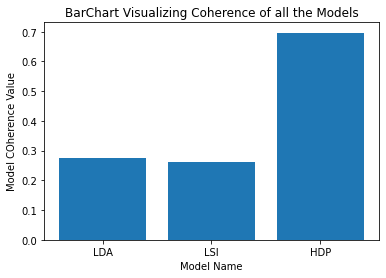

In [25]:
coherence = {"LDA" : coherennce_model_lda.get_coherence(), 
"LSI" : coherennce_model_lsi.get_coherence(), "HDP" : coherennce_model_hdp.get_coherence(), }

coherence_values = list(coherence.values())
model_name = list(coherence.keys())
plt.bar(model_name, coherence_values)

plt.xlabel("Model Name")
plt.ylabel("Model COherence Value")
plt.title("BarChart Visualizing Coherence of all the Models")

plt.show()